In [61]:
import sys
import time
import matplotlib.pyplot as plt # https://matplotlib.org/
import numpy as np # http://www.numpy.org/
import tekwfm
import os
from os.path import exists
from scipy import signal
from scipy import integrate
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.special import gamma
import matplotlib.cm as cm
from collections import Counter

import gc
import re
import tempfile
from collections import defaultdict, namedtuple
from pathlib import Path
import pandas as pd

In [62]:
doVerbose = False

#import the wfm file
filename_base = "030226_spe_2000_500_3_on_ch1"


#saving the processed file

folder_name = "PMT7_SPE_CLEAN"
file_name = "030226_spe_2000_500_3_on_ch1_processed_cleaned.csv" 
file_path = os.path.join(os.getcwd(), folder_name, file_name)


startEvent = 0
nEvents = 500

# code here to pass arguments

volts, tstart, tscale, tfrac, tdatefrac, tdate = tekwfm.read_wfm(filename_base+".wfm")
if doVerbose:
    print('>>>>', volts, tstart, tscale, tfrac, tdatefrac, tdate)

samples = volts.shape

print(len(volts))
print(tscale)
print('samples', samples[0])
tstop = samples[0]*tscale+tstart
sampleTimes = [tstart+x*tscale for x in range(samples[0])]


negVolts = [volts[:, event] for event in range(startEvent, startEvent + nEvents)] # all events, array of array of voltages
#tempVolts = -1 * negVolts # makes pulses positive
tempVolts = [-v for v in negVolts]

timestamps = np.array(tdatefrac) + np.array(tdate)
print(timestamps[0])
'''
for event in range(startEvent, startEvent+nEvents+1):
    tempVolt = volts[:,event]
    plt.figure(figsize=(6, 6))
    plt.plot(np.array(sampleTimes)*1e9,np.array(tempVolt)*1e3, color='black')
    plt.tick_params(axis='both', labelsize=12)
    plt.xlabel('Oscilloscope Timebase (ns)', fontsize=14)
    plt.xlim(-20,80)
    plt.ylabel('Voltage (mV)', fontsize=14)
    #plt.ylim(-25, 2)
    plt.show()
    del(tempVolt)
'''


12500
8e-11
samples 12500
1770134001.5660548


"\nfor event in range(startEvent, startEvent+nEvents+1):\n    tempVolt = volts[:,event]\n    plt.figure(figsize=(6, 6))\n    plt.plot(np.array(sampleTimes)*1e9,np.array(tempVolt)*1e3, color='black')\n    plt.tick_params(axis='both', labelsize=12)\n    plt.xlabel('Oscilloscope Timebase (ns)', fontsize=14)\n    plt.xlim(-20,80)\n    plt.ylabel('Voltage (mV)', fontsize=14)\n    #plt.ylim(-25, 2)\n    plt.show()\n    del(tempVolt)\n"

In [63]:
"""variables which can be changed"""
n=11 #threshold for pulses to cross, usually 15

baseline_end_frac = 0.01
pulse_end_frac = 0.99
amplitude_start_frac = 0.1
amplitude_end_frac = 1

timediffbins=1000 #number of bins in the histogram for time between each event
zoomedtimediffbins=100000 #number of bins in the zoomed in histogram for time between each event
zoom=0.0005 #the max x coordinate for zooming in on this histogram (looking at range 0 to 0.0005)

In [64]:
def calcbaseline(tempVolt, samples):
    baseline_voltages = tempVolt[0: int(baseline_end_frac*samples[0])]
    mean_b = np.mean(baseline_voltages)
    sigma_b = np.std(baseline_voltages, ddof=1)
    correct_tempVolt = tempVolt - mean_b
    return mean_b, sigma_b, correct_tempVolt



def calcamplitude(corrected_tempVolt, samples, sigma_b):
    min_height = 15 * sigma_b
    min_separation = int(0.04*samples[0])
    peaks, _ = find_peaks(corrected_tempVolt, height=min_height, distance=min_separation)
    number_of_peaks = len(peaks)
    if len(peaks) > 0:
        amplitude = corrected_tempVolt[peaks[0]]
        first_peak_index = peaks[0]
        first_peak_time = sampleTimes[first_peak_index]
    else:
        amplitude = np.max(corrected_tempVolt)
        amp_index = np.argmax(corrected_tempVolt)
        first_peak_index = amp_index
        first_peak_time = sampleTimes[first_peak_index]
    if amplitude > 0.22:
       number_of_peaks = 1

    return amplitude, first_peak_index, first_peak_time, number_of_peaks



def peak_FWHM(corrected_tempVolt, amplitude, first_peak_index, sampleTimes):   
    half_maximum = amplitude/2
    
    #left crossing of half maximum
    left = first_peak_index #begin at index of peak
    #move left until voltage rises to half maximum, stopping if left>0 (beginning of window reached)
    while left>0 and corrected_tempVolt[left]>half_maximum:
        left -= 1 #index moves left
    #interpolate between left and left+1
    if left == 0: #if beginning of window reached, take first time value as left crossing
        left_time = sampleTimes[0]
    else: 
        y1, y2 = corrected_tempVolt[left], corrected_tempVolt[left+1]
        x1, x2 = sampleTimes[left], sampleTimes[left+1]
        left_time = x1 + (half_maximum - y1)/(y2-y1) * (x2-x1)
        
    #same again for right
    right = first_peak_index
    while right<len(corrected_tempVolt)-1 and corrected_tempVolt[right]>half_maximum:
        right += 1
    #interpolate between right and right-1
    if right == len(corrected_tempVolt)-1: #if end of window reached, take last time value as right crossing
        right_time = sampleTimes[-1]
    else: 
        y1, y2 = corrected_tempVolt[right], corrected_tempVolt[right-1]
        x1, x2 = sampleTimes[right], sampleTimes[right-1]
        right_time = x1 + (half_maximum - y1)/(y2-y1) * (x2-x1)
    
    singleFWHM = right_time - left_time
    return singleFWHM, left_time, right_time


#threshold passed as an argument, n
def time_above_threshold(corrected, times, sigma_b, mean_b, first_peak_index, n):
    threshold = mean_b + n*sigma_b

    i = first_peak_index
    while i > 0 and corrected[i] > threshold:
        i -= 1
    # If we hit the boundary and are STILL above threshold → no crossing
    if i == 0 and corrected[i] > threshold:
        return None, None, None
    if i == len(corrected) - 1:
        # This implies the peak is at the very end, and the left search stopped
        # right at the end of the array, meaning we can't interpolate i to i+1.
        return None, None, None
    # Interpolate only if we actually crossed between i and i+1
    y1, y2 = corrected[i], corrected[i+1]
    x1, x2 = times[i], times[i+1]
    # Ensure interpolation makes physical sense
    if (y2 - y1) == 0:
        return None, None, None
    frac = (threshold - y1) / (y2 - y1)
    if not (0 <= frac <= 1):  
        return None, None, None
    first_cross = x1 + frac * (x2 - x1)

    j = first_peak_index
    while j < len(corrected)-1 and corrected[j] > threshold:
        j += 1
    if j == len(corrected)-1 and corrected[j] > threshold:
        return None, None, None
    y1, y2 = corrected[j-1], corrected[j]
    x1, x2 = times[j-1], times[j]
    if (y2 - y1) == 0:
        return None, None, None
    frac = (threshold - y1) / (y2 - y1)
    if not (0 <= frac <= 1):
        return None, None, None
    second_cross = x1 + frac * (x2 - x1)

    time_above = second_cross - first_cross
    if time_above <= 0:
        return None, None, None

    return time_above, first_cross, second_cross



#still use 3sigma for the integral bound 1
def calc_time_above_3sigma(corrected, times, sigma_b, mean_b, first_peak_index):
    threshold = mean_b + 3*sigma_b

    i = first_peak_index
    while i > 0 and corrected[i] > threshold:
        i -= 1
    # If we hit the boundary and are STILL above threshold → no crossing
    if i == 0 and corrected[i] > threshold:
        return None, None, None
    if i == len(corrected) - 1:
        # This implies the peak is at the very end, and the left search stopped
        # right at the end of the array, meaning we can't interpolate i to i+1.
        return None, None, None
    # Interpolate only if we actually crossed between i and i+1
    y1, y2 = corrected[i], corrected[i+1]
    x1, x2 = times[i], times[i+1]
    # Ensure interpolation makes physical sense
    if (y2 - y1) == 0:
        return None, None, None
    frac = (threshold - y1) / (y2 - y1)
    if not (0 <= frac <= 1):  
        return None, None, None
    first_3sigma_cross = x1 + frac * (x2 - x1)

    j = first_peak_index
    while j < len(corrected)-1 and corrected[j] > threshold:
        j += 1
    if j == len(corrected)-1 and corrected[j] > threshold:
        return None, None, None
    y1, y2 = corrected[j-1], corrected[j]
    x1, x2 = times[j-1], times[j]
    if (y2 - y1) == 0:
        return None, None, None
    frac = (threshold - y1) / (y2 - y1)
    if not (0 <= frac <= 1):
        return None, None, None
    second_3sigma_cross = x1 + frac * (x2 - x1)

    time_above_3sigma = second_3sigma_cross - first_3sigma_cross
    if time_above_3sigma <= 0:
        return None, None, None

    return time_above_3sigma, first_3sigma_cross, second_3sigma_cross



def time_index(first_3sigma_cross, sampleTimes):
    if first_3sigma_cross is None:
        return len(sampleTimes) - 1
    else:
        time_difference = np.abs(np.array(sampleTimes) - first_3sigma_cross)
        closest_index = np.argmin(time_difference)
        return closest_index
    


#integrate a single event
def single_charge_integral(corrected_tempVolt, sampleTimes, closest_index):
    # define bound 1 and 2
    bound_1 = closest_index
    bound_2 = int(pulse_end_frac*len(corrected_tempVolt))
    integral_voltages = corrected_tempVolt[bound_1:bound_2]
    time_slice = sampleTimes[bound_1:bound_2]
    single_integral = integrate.trapezoid(integral_voltages, x=time_slice)
    #return a single number for the integral of one event
    return single_integral



def correcting_tempVolts(tempVolts, mean_b):
    corrected_tempVolts = []
    for i, tempVolt in enumerate(tempVolts):
        corrected = tempVolt - mean_b[i]
        corrected_tempVolts.append(corrected)
    return corrected_tempVolts


In [65]:
"""Working on all events"""
mean_b_array = []
sigma_b_array = []
corrected_tempVolts = []
all_amplitudes = []
all_peak_times = []
all_peak_indices = []
all_FWHM = []
all_t1 = []
all_t2 = []
all_time_above_thresh = []
all_first_crossing = []
all_second_crossing = []
all_tabove_3sig = []
all_first_t_3sig = []
all_second_t_3sig = []
all_closest_indices = []
all_integrals = []
all_number_of_peaks = []

for tempVolt in tempVolts:
    mean_b, sigma_b, corrected_tempVolt = calcbaseline(tempVolt, samples)
    mean_b_array.append(mean_b)
    sigma_b_array.append(sigma_b)
    corrected_tempVolts.append(corrected_tempVolt)

mean_b_array = np.array(mean_b_array)
sigma_b_array = np.array(sigma_b_array)
corrected_tempVolts = np.array(corrected_tempVolts)

for event_index, corrected_tempVolt in enumerate(corrected_tempVolts):

    amplitude, first_peak_index, first_peak_time, number_of_peaks = calcamplitude(corrected_tempVolt, samples, sigma_b_array[event_index])
    singleFWHM, left_time, right_time = peak_FWHM(corrected_tempVolt, amplitude, first_peak_index, sampleTimes)
    time_above, first_cross, second_cross = time_above_threshold(corrected_tempVolt, sampleTimes, sigma_b_array[event_index], mean_b_array[event_index], first_peak_index, n)
    time_above_3sigma, first_3sigma_cross, second_3sigma_cross = calc_time_above_3sigma(corrected_tempVolt, sampleTimes, sigma_b_array[event_index], mean_b_array[event_index], first_peak_index)
    closest_index = time_index(first_3sigma_cross, sampleTimes)
    single_integral = single_charge_integral(corrected_tempVolt, sampleTimes, closest_index)

    all_amplitudes.append(amplitude)
    all_peak_times.append(first_peak_time)
    all_peak_indices.append(first_peak_index)
    all_FWHM.append(singleFWHM)
    all_t1.append(left_time)
    all_t2.append(right_time)
    all_time_above_thresh.append(time_above)
    all_first_crossing.append(first_cross)
    all_second_crossing.append(second_cross)
    all_tabove_3sig.append(time_above_3sigma)
    all_first_t_3sig.append(first_3sigma_cross)
    all_second_t_3sig.append(second_3sigma_cross) 
    all_closest_indices.append(closest_index)
    all_integrals.append(single_integral)
    all_number_of_peaks.append(number_of_peaks)

all_amplitudes = np.array(all_amplitudes)
all_peak_times = np.array(all_peak_times)
all_peak_indices = np.array(all_peak_indices)
all_FWHM = np.array(all_FWHM)
all_t1 = np.array(all_t1)
all_t2 = np.array(all_t2)
all_time_above_thresh = np.array(all_time_above_thresh)
all_first_crossing = np.array(all_first_crossing)
all_second_crossing = np.array(all_second_crossing)
all_tabove_3sig = np.array(all_tabove_3sig)
all_first_t_3sig = np.array(all_first_t_3sig)
all_second_t_3sig = np.array(all_second_t_3sig)
all_closest_indices = np.array(all_closest_indices)
all_integrals = np.array(all_integrals)
all_number_of_peaks = np.array(all_number_of_peaks)

print('Analysis done, now printing plots')

"""deadtime analysis"""
event_timestamps = np.array(tdatefrac) + np.array(tdate)
event_time_diff = np.diff(event_timestamps)


Resistance = ((1/10000) + (1/50))**(-1)
all_integrals_picocharge = (all_integrals * 1e12) / Resistance


Analysis done, now printing plots


<>:201: SyntaxWarning: invalid escape sequence '\s'
<>:201: SyntaxWarning: invalid escape sequence '\s'
/var/folders/54/shy8r4g15d33hf9px0m5hytc0000gn/T/ipykernel_59174/1297091861.py:201: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('Times of first passing the 15$\sigma$ baseline threshold (ns)')


Fit failed during iteration 3. Stopping.


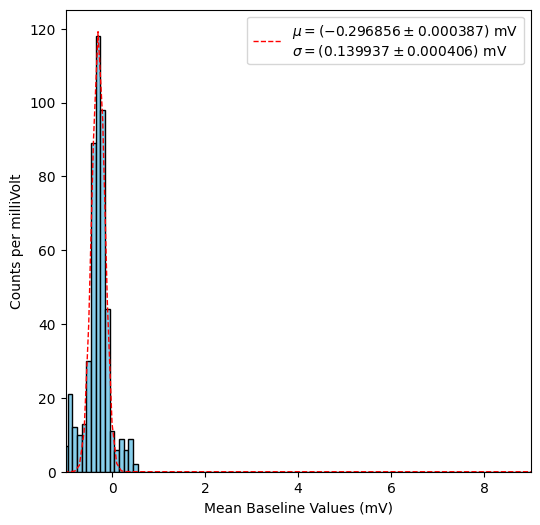

Converged after 2 iterations.


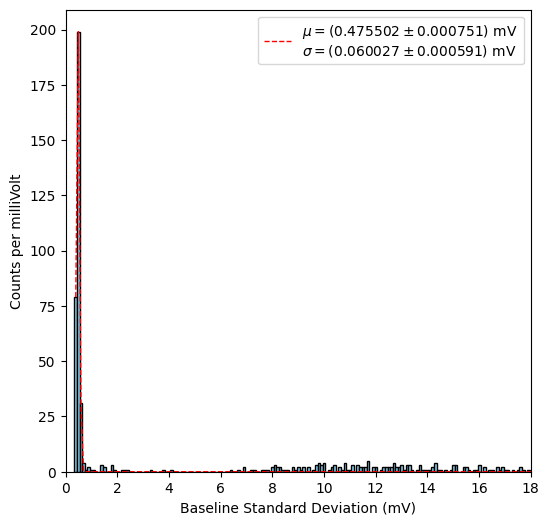

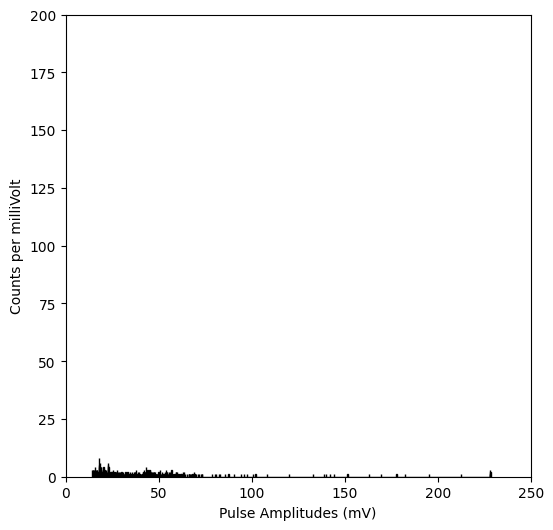

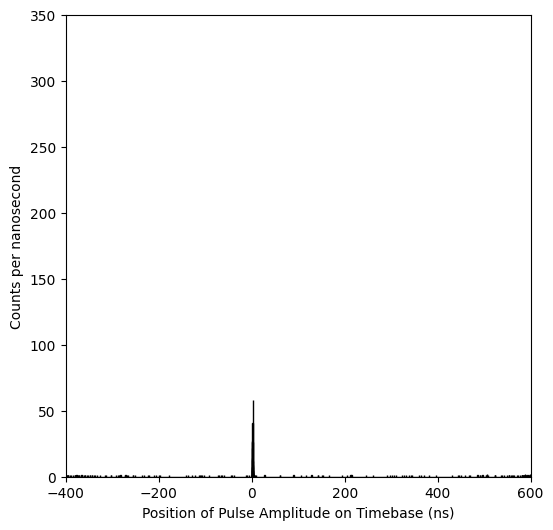

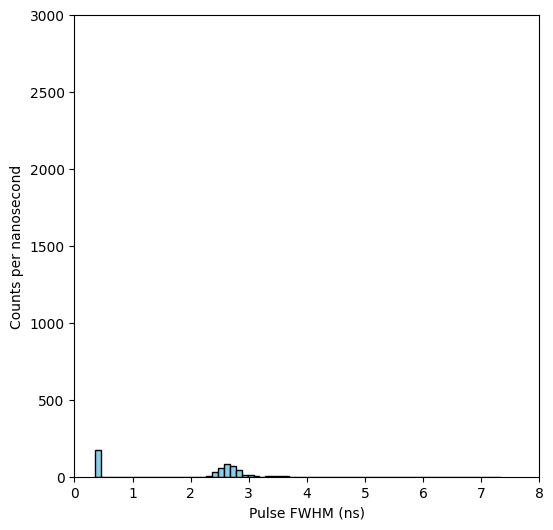

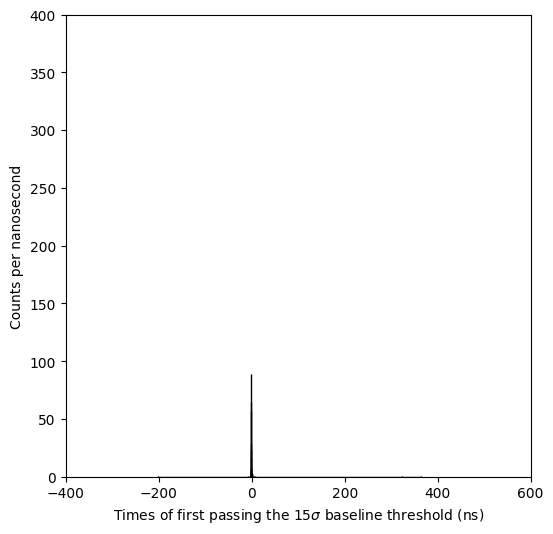

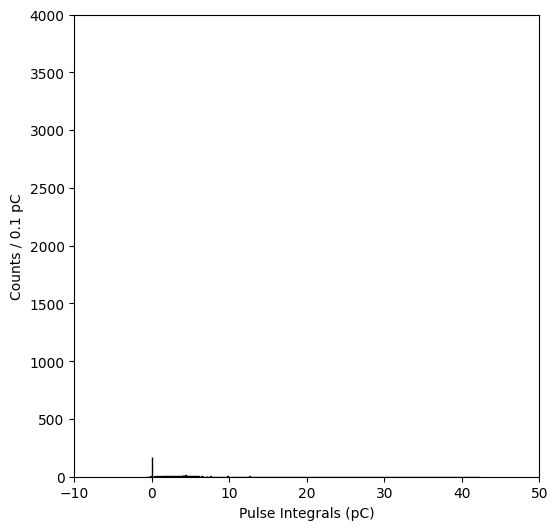

4.703809668810779 21.707559510859213


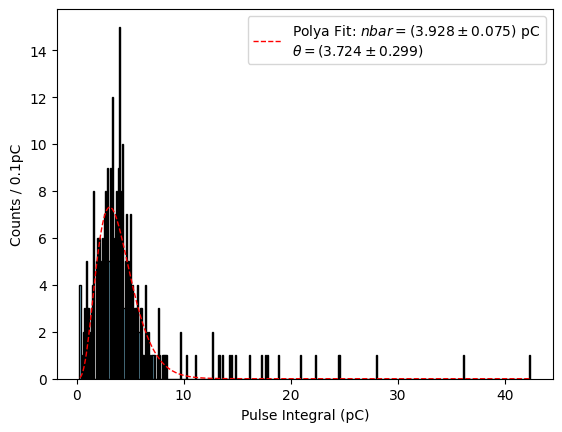

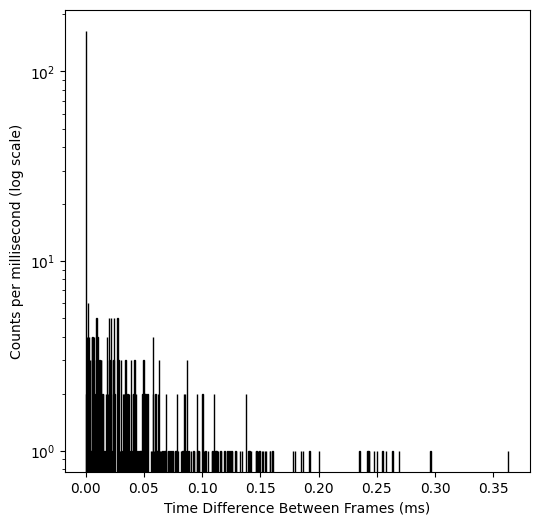

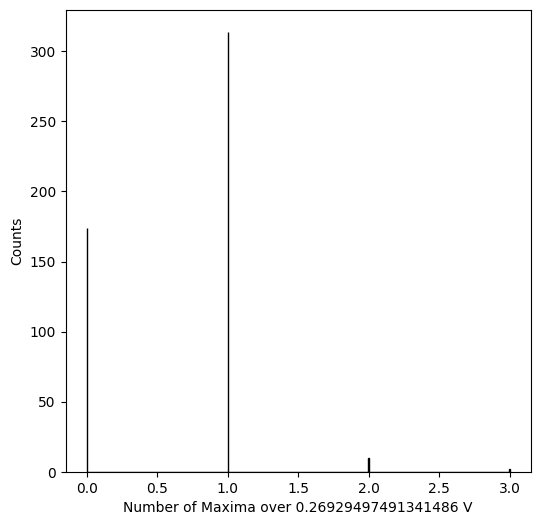

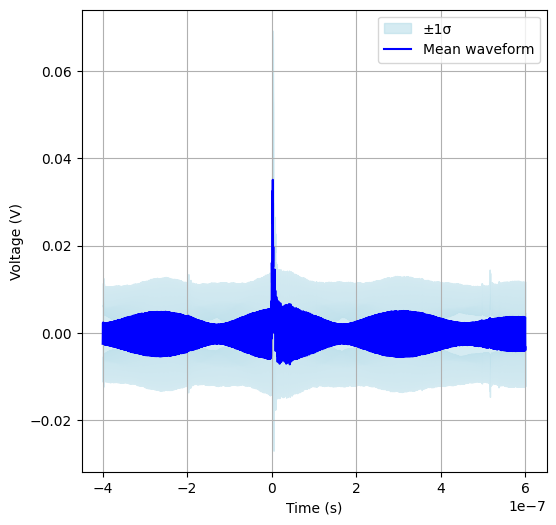

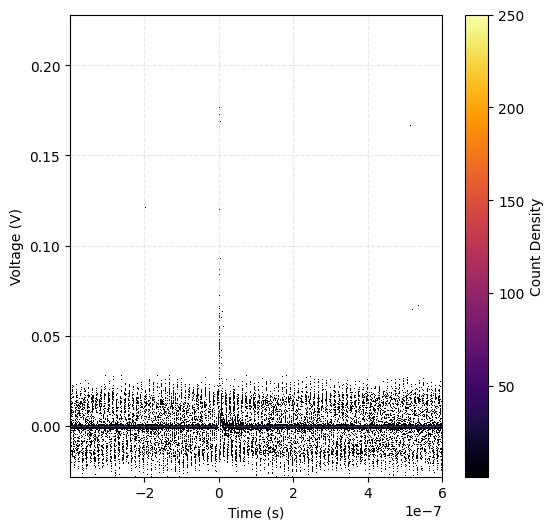

Plots complete, now cleaning


In [66]:
"""Making the histograms for the data"""
mean_b_array_mV = mean_b_array * 1000
sigma_b_array_mV = sigma_b_array * 1000

# histogram and gaussian for baseline mean
plt.figure(figsize=(6, 6))
def gaussian_mb(mean_b_array_mV, amp,  mu, sigma):
    gauss_mb = amp * (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp((-0.5 * (mean_b_array_mV - mu)**2)/ sigma**2)
    return gauss_mb

bm_number_of_bins = int((np.max(mean_b_array_mV)-np.min(mean_b_array_mV))/0.1) #chosen 1 bin = 0.1 mV
n, bins, patches = plt.hist(mean_b_array_mV, bins=bm_number_of_bins, color = 'skyblue', edgecolor = 'black')
bin_centers = 0.5 * (bins[1:] + bins[:-1])

MAX_ITERATIONS = 3
SIGMA_THRESHOLD = 3.0  # Remove points > 3 standard deviations away

X_fit = bin_centers.copy()
Y_fit = n.copy()
p0 = [np.max(n), np.mean(bin_centers), np.std(bin_centers)]

final_popt = None
final_pcov = None
final_mask = None

for i in range(MAX_ITERATIONS):
    try:
        # 1. Fit the current data
        popt, pcov = curve_fit(gaussian_mb, X_fit, Y_fit, p0=p0)
        # store results
        final_popt = popt
        final_pcov = pcov
        # 2. Calculate the fitted curve and residuals
        Y_fitted = gaussian_mb(X_fit, *popt)
        residuals = Y_fit - Y_fitted
        # 3. Calculate the standard deviation of the residuals (a measure of fit scatter)
        residual_std = np.std(residuals)
        
        # 4. Create a mask to identify outliers
        mask = np.abs(residuals) < (SIGMA_THRESHOLD * residual_std)
        
        # If no points are removed, the process is stable; stop
        if np.all(mask):
            print(f"Converged after {i+1} iterations.")
            break
            
        # 5. Apply the mask to remove outliers for the next iteration
        X_fit = X_fit[mask]
        Y_fit = Y_fit[mask]
        
        # Update the initial guess (p0) for the next iteration with the current fit
        p0 = popt
        
    except RuntimeError:
        print(f"Fit failed during iteration {i+1}. Stopping.")
        break
else:
    print(f"Fit completed max {MAX_ITERATIONS} iterations.")
# calculate final errors and plot
if final_popt is None:
    print("Error: No successful fit achieved.")
else:
    mb_fit_full = gaussian_mb(bin_centers, *final_popt)
    err_mu = np.sqrt(final_pcov[1,1])
    err_sigma = np.sqrt(final_pcov[2,2])
    plt.plot(bin_centers, mb_fit_full, 'r--', linewidth=1)
    plt.xlim(-1, 9)
    plt.xlabel('Mean Baseline Values (mV)')
    plt.ylabel('Counts per milliVolt')
    plt.legend([
    r'$\mu=(%.6f \pm %.6f)\ \mathrm{mV}$'  # First line: Mean ($\mu$)
    '\n'                                              # Newline character
    r'$\sigma=(%.6f \pm %.6f)\ \mathrm{mV}$' % (        # Second line: Std Dev ($\sigma$)
        popt[1], err_mu, popt[2], err_sigma)], loc='best', fontsize=10)
    plt.show()



# histogram and gaussian for baseline standard deviations
plt.figure(figsize=(6, 6))

def gaussian_sb(sigma_b_array_mV, amp,  mu, sigma):
    gauss_sb = amp * (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp((-0.5 * (sigma_b_array_mV - mu)**2)/ sigma**2)
    return gauss_sb

sb_number_of_bins = int((np.max(sigma_b_array_mV)-np.min(sigma_b_array_mV))/0.1) #chosen 1 bin = 0.1mV
n, bins, patches = plt.hist(sigma_b_array_mV, bins=sb_number_of_bins, color='skyblue', edgecolor='black')
bin_centers = 0.5 * (bins[1:] + bins[:-1])
MAX_ITERATIONS = 3
SIGMA_THRESHOLD = 3.0  # Remove points > 3 standard deviations away

fit_mask = (bin_centers >=0) & (bin_centers <=2)
bin_centers_filtered = bin_centers[fit_mask]
n_filtered = n[fit_mask]

X_fit = bin_centers_filtered.copy()
Y_fit = n_filtered.copy()
p0 = [np.max(n_filtered), np.mean(bin_centers_filtered), np.std(bin_centers_filtered)]

final_popt = None
final_pcov = None
final_mask = None

for i in range(MAX_ITERATIONS):
    try:
        # 1. Fit the current data
        popt, pcov = curve_fit(gaussian_sb, X_fit, Y_fit, p0=p0)
        # store results
        final_popt = popt
        final_pcov = pcov
        # 2. Calculate the fitted curve and residuals
        Y_fitted = gaussian_sb(X_fit, *popt)
        residuals = Y_fit - Y_fitted
        # 3. Calculate the standard deviation of the residuals (a measure of fit scatter)
        residual_std = np.std(residuals)
        
        # 4. Create a mask to identify outliers
        mask = np.abs(residuals) < (SIGMA_THRESHOLD * residual_std)
        
        # If no points are removed, the process is stable; stop
        if np.all(mask):
            print(f"Converged after {i+1} iterations.")
            break
            
        # 5. Apply the mask to remove outliers for the next iteration
        X_fit = X_fit[mask]
        Y_fit = Y_fit[mask]
        
        # Update the initial guess (p0) for the next iteration with the current fit
        p0 = popt
        
    except RuntimeError:
        print(f"Fit failed during iteration {i+1}. Stopping.")
        break
else:
    print(f"Fit completed max {MAX_ITERATIONS} iterations.")
# calculate final errors and plot
if final_popt is None:
    print("Error: No successful fit achieved.")
else:
    sb_fit_full = gaussian_sb(bin_centers, *final_popt)
    err_mu = np.sqrt(final_pcov[1,1])
    err_sigma = np.sqrt(final_pcov[2,2])
    plt.plot(bin_centers, sb_fit_full, 'r--', linewidth=1)
    plt.xlim(0, 18)
    plt.xlabel('Baseline Standard Deviation (mV)')
    plt.ylabel('Counts per milliVolt')
    plt.legend([
    r'$\mu=(%.6f \pm %.6f)\ \mathrm{mV}$'  # First line: Mean ($\mu$)
    '\n'                                              # Newline character
    r'$\sigma=(%.6f \pm %.6f)\ \mathrm{mV}$' % (        # Second line: Std Dev ($\sigma$)
        popt[1], err_mu, popt[2], err_sigma)], loc='best', fontsize=10)
    plt.show()
    mean_bsd = final_popt[1]
    sigma_bsd = final_popt[2]

# histogram for Peak Amplitudes
plt.figure(figsize=(6, 6))
all_amplitudes_mV = all_amplitudes * 1000
amp_number_of_bins = int((np.max(all_amplitudes_mV)-np.min(all_amplitudes_mV))/0.1) #chosen 1 bin = 0.1mV
plt.hist(all_amplitudes_mV, bins=amp_number_of_bins, color='skyblue', edgecolor='black')
plt.xlim(0,250)
plt.ylim(0,200)
plt.xlabel('Pulse Amplitudes (mV)')
plt.ylabel('Counts per milliVolt')
plt.show()

# histogram of Peak Times
plt.figure(figsize=(6, 6))
all_peak_times_ns = all_peak_times *1e9
pt_number_of_bins = int((np.max(all_peak_times_ns)-np.min(all_peak_times_ns))/0.1) #chosen 1 bin = 0.1ns
plt.hist(all_peak_times_ns, bins=pt_number_of_bins, color='skyblue', edgecolor='black')
plt.xlim(-400,600)
plt.ylim(0,350)
plt.xlabel('Position of Pulse Amplitude on Timebase (ns)')
plt.ylabel('Counts per nanosecond')
plt.show()

# histogram for FWHM values
plt.figure(figsize=(6, 6))
all_FWHM_ns = all_FWHM * 1e9
fwhm_number_of_bins = int((np.max(all_FWHM_ns)-np.min(all_FWHM_ns))/0.1) #chosen 1 bin = 0.1ns
plt.hist(all_FWHM_ns, bins=fwhm_number_of_bins, color='skyblue', edgecolor='black')
plt.xlim(0,8)
plt.ylim(0,3000)
plt.xlabel('Pulse FWHM (ns)')
plt.ylabel('Counts per nanosecond')
plt.show()

# histogram for first crossings of 15sigma threshold
filtered_crossings = [t for t in all_first_crossing if t is not None]
if len(filtered_crossings) > 1:
    filtered_crossings_ns = np.array(filtered_crossings) * 1e9

    crosst_number_of_bins = int((np.max(filtered_crossings_ns) - np.min(filtered_crossings_ns)) / 0.1) #chosen 1 bin = 0.1ns

    plt.figure(figsize=(6, 6))
    plt.hist(filtered_crossings_ns, bins=crosst_number_of_bins, color='skyblue', edgecolor='black')
    plt.xlim(-400,600)
    plt.ylim(0,400)
    plt.xlabel('Times of first passing the 15$\sigma$ baseline threshold (ns)')
    plt.ylabel('Counts per nanosecond')
    plt.show()
else:
    print("Cannot plot histogram: Fewer than two valid first crossing times found.")

'''
# histogram of pulse integrals in Vs
plt.figure(figsize=(6, 6))
int_number_of_bins = int((np.max(all_integrals)-np.min(all_integrals))/1e-11) #chosen 1 bin = 10Vps
plt.hist(all_integrals, bins=int_number_of_bins, color='skyblue', edgecolor='black')
#plt.xlim(-0.5e-9, 4e-9)
#plt.ylim(0,1500)
plt.xlabel('Pulse Integrals (Vs)')
plt.ylabel('Counts per Voltsecond')
plt.show()
'''
# histogram of pulse integrals in units of charge
Resistance = ((1/10000) + (1/50))**(-1)
all_integrals_picocharge = (all_integrals * 1e12) / Resistance
plt.figure(figsize=(6, 6))
int_number_of_bins = int((np.max(all_integrals_picocharge)-np.min(all_integrals_picocharge))/0.1) #chosen 1 bin = 0.1 pC
plt.hist(all_integrals_picocharge, bins=int_number_of_bins, color='skyblue', edgecolor='black')
plt.xlim(-10, 50)
plt.ylim(0,4000)
plt.xlabel('Pulse Integrals (pC)')
plt.ylabel('Counts / 0.1 pC')
plt.show()

# Adding polya distribution to pulse integral graph
positive_charge_data = all_integrals_picocharge[all_integrals_picocharge > 0]
def polya_dist(positive_charge_data, A, nbar, theta):
    # A = amplitide/normalisation factor
    polya_PMF = A*((theta + 1)**(theta + 1))*(1/gamma(theta + 1))*((positive_charge_data/nbar)**theta)*np.exp(-(theta + 1)*(positive_charge_data/nbar))
    return polya_PMF

Delta_x = 0.1 
int_number_of_bins = int((np.max(positive_charge_data) - np.min(positive_charge_data)) / Delta_x)
n, bins, patches = plt.hist(positive_charge_data, bins=int_number_of_bins, color='skyblue', edgecolor='black')
bin_centers = 0.5 * (bins[1:] + bins[:-1])

initial_nbar = np.mean(positive_charge_data)
initial_var = np.var(positive_charge_data) 
print(initial_nbar, initial_var)
N_events = len(positive_charge_data)
initial_A = N_events * Delta_x
initial_theta = np.abs((initial_nbar**2 / initial_var) - 1)

p0 = [initial_A, initial_nbar, initial_theta]

popt, pcov = curve_fit(polya_dist, bin_centers, n , p0=p0, absolute_sigma=True, maxfev=10000)
A_fit, nbar_fit, theta_fit = popt
err_A = np.sqrt(pcov[0, 0])
err_nbar = np.sqrt(pcov[1, 1])
err_theta = np.sqrt(pcov[2, 2])
polya_dist_fit = polya_dist(bin_centers, *popt)

plt.plot(bin_centers, polya_dist_fit, 'r--', linewidth=1)
plt.xlabel('Pulse Integral (pC)')
plt.ylabel('Counts / 0.1pC')
plt.legend([
   r'Polya Fit: $nbar=(%.3f \pm %.3f)\ \mathrm{pC}$'
        '\n'
        r'$\theta=(%.3f \pm %.3f)$' % (
            nbar_fit, err_nbar,
            theta_fit, err_theta)], loc='best', fontsize=10)
plt.show()

"""deadtime analysis"""
event_timestamps = np.array(tdatefrac) + np.array(tdate)

event_time_diff = np.diff(event_timestamps)

#making histogram, change number of bins later
plt.figure(figsize=(6, 6))
plt.hist(event_time_diff[:-1], bins=timediffbins, edgecolor='black')
plt.yscale('log')  # set y-axis to logarithmic scale
plt.xlabel('Time Difference Between Frames (ms)')
plt.ylabel('Counts per millisecond (log scale)')
plt.show()
'''
#zoomed in histogram
plt.figure(figsize=(6, 6))
plt.hist(event_time_diff[:-1], bins=zoomedtimediffbins, edgecolor='black')
plt.yscale('log')  # set y-axis to logarithmic scale
plt.xlabel('Time Difference Between Frames (ms)')
plt.ylabel('Counts per millisecond (log scale)')
plt.xlim(0, zoom) # zoom into interesting range (0 to 0.5us)
plt.show()
'''
#previous code for just a set value
event_numbers = []
number_of_multiple_maxima = []
number_of_maxima_all = []

#maximum_threshold = 0.03 #threshold for code to consider a peak a maximum in the event, eg. 30mV
min_peak_sep = 0.1*samples[0] #minimum separate between 'peaks' eg. 10% of all samples

#loop over events
for event_index, corrected_tempVolt in enumerate(corrected_tempVolts):
    count = 0  #reset counter of maxima
    prev_max_index = -min_peak_sep
    maximum_threshold = 15 * sigma_b_array[event_index]
    #loop over all voltage points in each event
    
    for i, voltage in enumerate(corrected_tempVolt):
        if voltage > maximum_threshold:
            if i - prev_max_index >= min_peak_sep:
                count += 1  #count number of times passes below threshold
                prev_max_index = i
    #add ALL event counts to all maxima array
    number_of_maxima_all.append(count)

    if count > 1: #store events with more than 1 maximum
        event_numbers.append(event_index) 
        number_of_multiple_maxima.append(count) 

event_numbers = np.array(event_numbers)
number_of_multiple_maxima = np.array(number_of_multiple_maxima)   
number_of_maxima_all = np.array(number_of_maxima_all)

#plot histogram of number of maxima
plt.figure(figsize=(6, 6))
plt.hist(number_of_maxima_all, bins=1000, edgecolor='black')
plt.xlabel(f'Number of Maxima over {maximum_threshold} V')
plt.ylabel('Counts')
plt.show()

""" Creating Average Waveform from all the data """

def average_waveform(tempVolts):
    numEvents = len(tempVolts)
    numSamples = len(tempVolts[0])
    mean_waveform = []
    std_waveform = []

    for i in range(numSamples): # loop over each time point in the waveform
        sample_values = [tempVolts[event][i] for event in range(numEvents)]  # creates a list of voltages at the same time point across all events
        mean_waveform.append(np.mean(sample_values))
        std_waveform.append(np.std(sample_values))
    return np.array(mean_waveform), np.array(std_waveform)

mean_waveform, std_waveform = average_waveform(tempVolts)

plt.figure(figsize=(6, 6))
plt.fill_between(sampleTimes,
                 mean_waveform - std_waveform,
                 mean_waveform + std_waveform,
                 color='lightblue', alpha=0.5, label='±1σ')

plt.plot(sampleTimes, mean_waveform, label='Mean waveform', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
#plt.title('Average Waveform')
plt.legend()
plt.grid(True)
plt.show()

# creating heat map
tempVolts_array = np.array(tempVolts)
all_voltages = tempVolts_array.flatten()
num_events = tempVolts_array.shape[0]
all_times = np.tile(sampleTimes, num_events)

voltage_range = np.max(all_voltages) - np.min(all_voltages)
desired_bin_width = 0.0001
num_voltage_bins = int(voltage_range / desired_bin_width)
if num_voltage_bins < 1:
    num_voltage_bins = 1

num_time_bins = tempVolts_array.shape[1]

plt.figure(figsize=(6,6))
hist, xedges, yedges, im = plt.hist2d( all_times, all_voltages, bins=[num_time_bins, num_voltage_bins], cmap=cm.inferno, cmin=1, vmax = 250)
cbar = plt.colorbar(im)

cbar.set_label('Count Density')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
#plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

print('Plots complete, now cleaning')



In [67]:
"""export data in a csv"""

df = pd.DataFrame({
            'baseline': mean_b_array,
            'sd_baseline': sigma_b_array,
            'amplitude': all_amplitudes,
            'peak_time': all_peak_times,
            'FWHM': all_FWHM,
            't1_of_FWHM': all_t1,
            't2_of_FWHM': all_t2,
            'time_above_threshold': all_time_above_thresh,
            'first_threshold_crossing': all_first_crossing,
            'second_threshold_crossing': all_second_crossing,
            'integral_pC': all_integrals_picocharge,
            'peaks_over_threshold': all_number_of_peaks,               
            })


#df.to_csv(file_path, sep=',', encoding='utf-8-sig', index=True, header=True)

print('CSV done!')

CSV done!


In [68]:
#cut noise out! Anything with sigma baseline above 3sigma of gaussian fit. Only export these to the csv file. 

good_indices = [i for i, event_sd in enumerate(sigma_b_array_mV) if abs(event_sd - mean_bsd)<=15*sigma_bsd]

#Filter all arrays
sigma_b_array_mV = sigma_b_array_mV[good_indices]
sigma_b_array = sigma_b_array[good_indices]
mean_b_array_mV = mean_b_array_mV[good_indices]
mean_b_array = mean_b_array[good_indices]
corrected_tempVolts = corrected_tempVolts[good_indices]

all_amplitudes = all_amplitudes[good_indices]
all_peak_times = all_peak_times[good_indices]
all_peak_indices = all_peak_indices[good_indices]
all_FWHM = all_FWHM[good_indices]
all_t1 = all_t1[good_indices]
all_t2 = all_t2[good_indices]
all_time_above_thresh = all_time_above_thresh[good_indices]
all_first_crossing = all_first_crossing[good_indices]
all_second_crossing = all_second_crossing[good_indices]
all_closest_indices = all_closest_indices[good_indices]
all_integrals = all_integrals[good_indices]
all_number_of_peaks = all_number_of_peaks[good_indices]
all_tabove_3sig = all_tabove_3sig[good_indices]
all_first_t_3sig = all_first_t_3sig[good_indices]
all_second_t_3sig = all_second_t_3sig[good_indices]


print(f"{len(good_indices)} events remain.")

320 events remain.


<>:201: SyntaxWarning: invalid escape sequence '\s'
<>:201: SyntaxWarning: invalid escape sequence '\s'
/var/folders/54/shy8r4g15d33hf9px0m5hytc0000gn/T/ipykernel_59174/1793882544.py:201: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('Times of first passing the 15$\sigma$ baseline threshold (ns)')


Fit completed max 3 iterations.


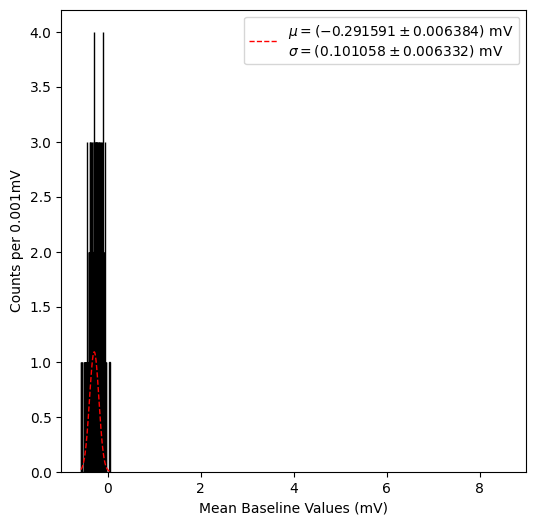

Fit completed max 3 iterations.


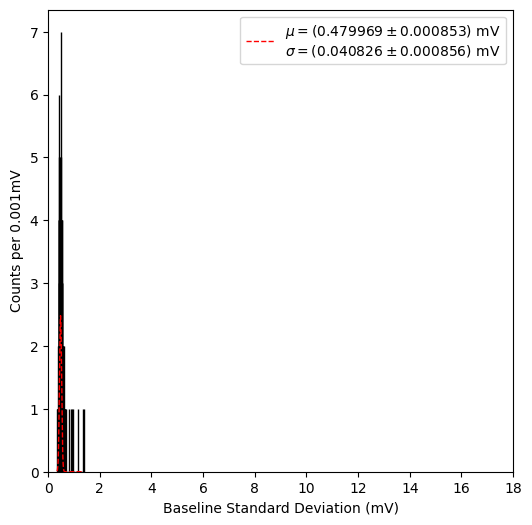

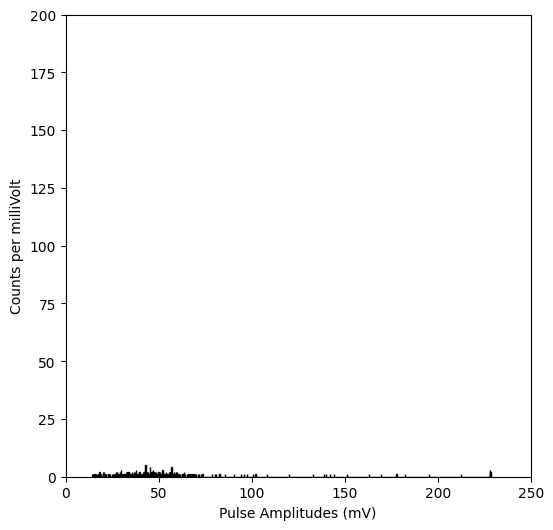

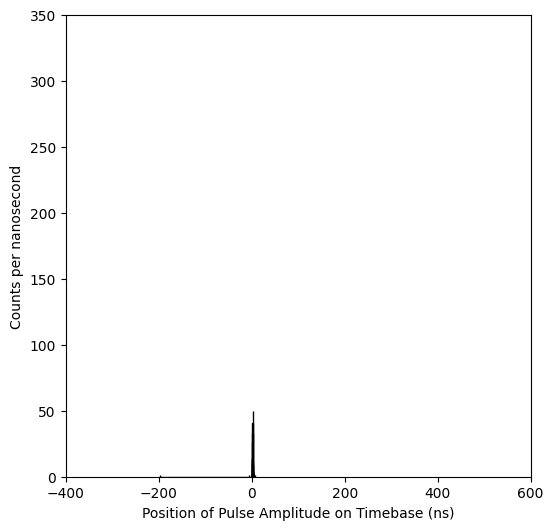

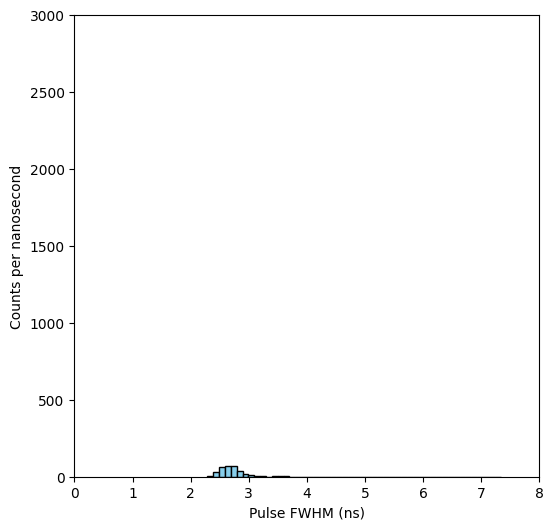

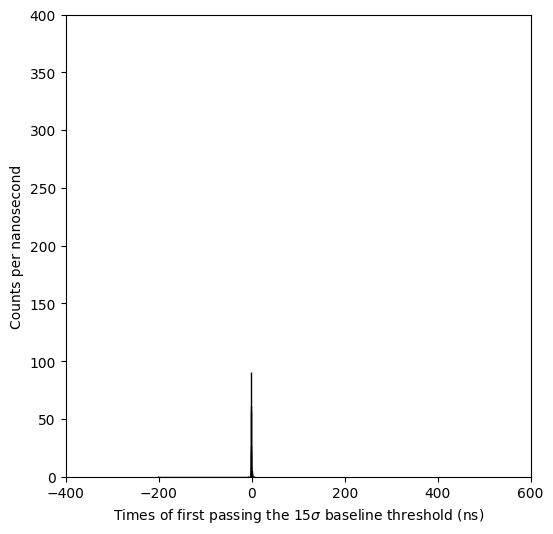

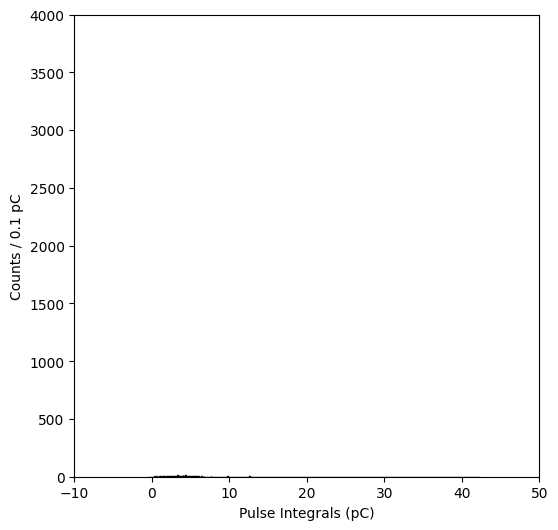

4.777636055137617 22.107059442878306


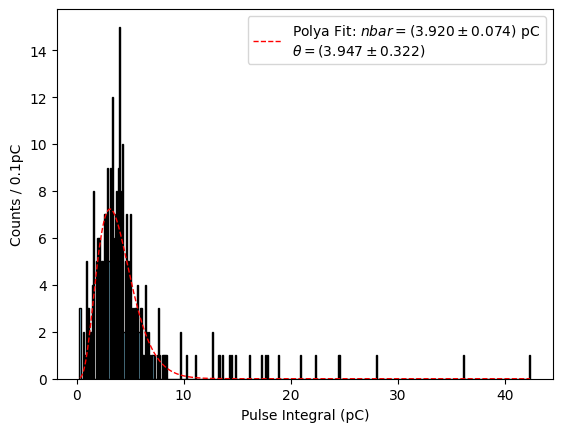

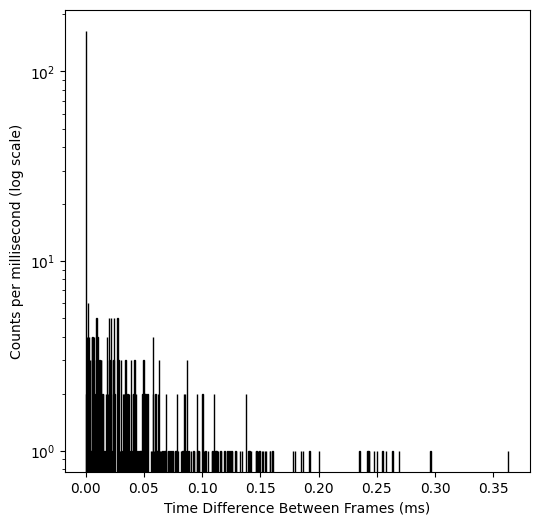

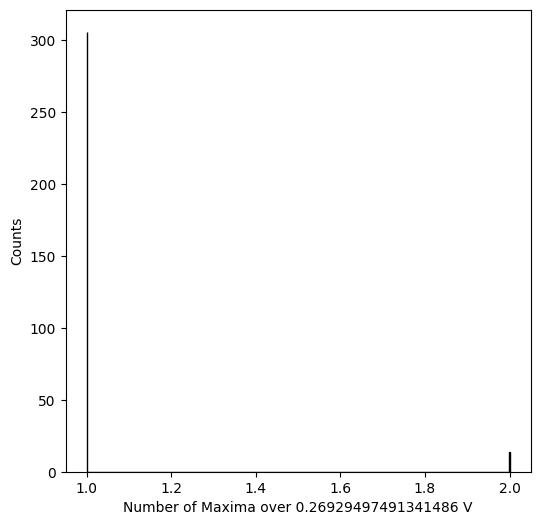

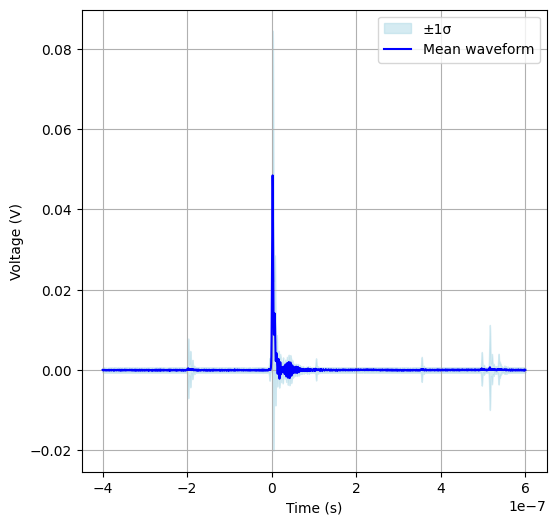

320


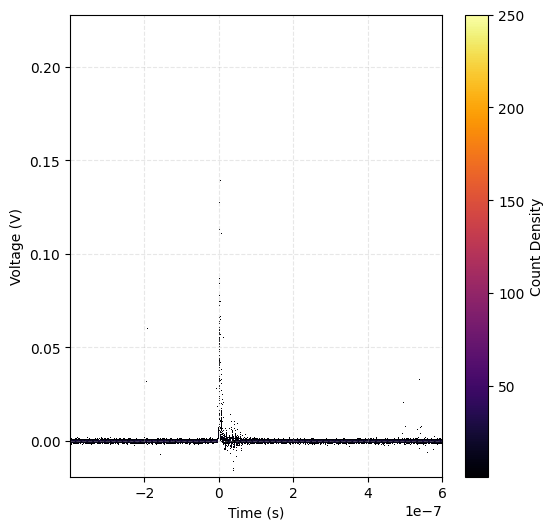

Cleaned plots complete, now making csv


In [69]:
"""Making the histograms for the cleaned data"""
mean_b_array_mV = mean_b_array * 1000
sigma_b_array_mV = sigma_b_array * 1000

# histogram and gaussian for baseline mean
plt.figure(figsize=(6, 6))
def gaussian_mb(mean_b_array_mV, amp,  mu, sigma):
    gauss_mb = amp * (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp((-0.5 * (mean_b_array_mV - mu)**2)/ sigma**2)
    return gauss_mb

bm_number_of_bins = int((np.max(mean_b_array_mV)-np.min(mean_b_array_mV))/0.001) #chosen 1 bin = 0.001 mV
n, bins, patches = plt.hist(mean_b_array_mV, bins=bm_number_of_bins, color = 'skyblue', edgecolor = 'black')
bin_centers = 0.5 * (bins[1:] + bins[:-1])

MAX_ITERATIONS = 3
SIGMA_THRESHOLD = 3.0  # Remove points > 3 standard deviations away

X_fit = bin_centers.copy()
Y_fit = n.copy()
p0 = [np.max(n), np.mean(bin_centers), np.std(bin_centers)]

final_popt = None
final_pcov = None
final_mask = None

for i in range(MAX_ITERATIONS):
    try:
        # 1. Fit the current data
        popt, pcov = curve_fit(gaussian_mb, X_fit, Y_fit, p0=p0)
        # store results
        final_popt = popt
        final_pcov = pcov
        # 2. Calculate the fitted curve and residuals
        Y_fitted = gaussian_mb(X_fit, *popt)
        residuals = Y_fit - Y_fitted
        # 3. Calculate the standard deviation of the residuals (a measure of fit scatter)
        residual_std = np.std(residuals)
        
        # 4. Create a mask to identify outliers
        mask = np.abs(residuals) < (SIGMA_THRESHOLD * residual_std)
        
        # If no points are removed, the process is stable; stop
        if np.all(mask):
            print(f"Converged after {i+1} iterations.")
            break
            
        # 5. Apply the mask to remove outliers for the next iteration
        X_fit = X_fit[mask]
        Y_fit = Y_fit[mask]
        
        # Update the initial guess (p0) for the next iteration with the current fit
        p0 = popt
        
    except RuntimeError:
        print(f"Fit failed during iteration {i+1}. Stopping.")
        break
else:
    print(f"Fit completed max {MAX_ITERATIONS} iterations.")
# calculate final errors and plot
if final_popt is None:
    print("Error: No successful fit achieved.")
else:
    mb_fit_full = gaussian_mb(bin_centers, *final_popt)
    err_mu = np.sqrt(final_pcov[1,1])
    err_sigma = np.sqrt(final_pcov[2,2])
    plt.plot(bin_centers, mb_fit_full, 'r--', linewidth=1)
    plt.xlim(-1, 9)
    plt.xlabel('Mean Baseline Values (mV)')
    plt.ylabel('Counts per 0.001mV')
    plt.legend([
    r'$\mu=(%.6f \pm %.6f)\ \mathrm{mV}$'  # First line: Mean ($\mu$)
    '\n'                                              # Newline character
    r'$\sigma=(%.6f \pm %.6f)\ \mathrm{mV}$' % (        # Second line: Std Dev ($\sigma$)
        popt[1], err_mu, popt[2], err_sigma)], loc='best', fontsize=10)
    plt.show()



# histogram and gaussian for baseline standard deviations
plt.figure(figsize=(6, 6))

def gaussian_sb(sigma_b_array_mV, amp,  mu, sigma):
    gauss_sb = amp * (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp((-0.5 * (sigma_b_array_mV - mu)**2)/ sigma**2)
    return gauss_sb

sb_number_of_bins = int((np.max(sigma_b_array_mV)-np.min(sigma_b_array_mV))/0.001) #chosen 1 bin = 0.001mV
n, bins, patches = plt.hist(sigma_b_array_mV, bins=sb_number_of_bins, color='skyblue', edgecolor='black')
bin_centers = 0.5 * (bins[1:] + bins[:-1])
MAX_ITERATIONS = 3
SIGMA_THRESHOLD = 3.0  # Remove points > 3 standard deviations away

fit_mask = (bin_centers >=0) & (bin_centers <=2)
bin_centers_filtered = bin_centers[fit_mask]
n_filtered = n[fit_mask]

X_fit = bin_centers_filtered.copy()
Y_fit = n_filtered.copy()
p0 = [np.max(n_filtered), np.mean(bin_centers_filtered), np.std(bin_centers_filtered)]

final_popt = None
final_pcov = None
final_mask = None

for i in range(MAX_ITERATIONS):
    try:
        # 1. Fit the current data
        popt, pcov = curve_fit(gaussian_sb, X_fit, Y_fit, p0=p0)
        # store results
        final_popt = popt
        final_pcov = pcov
        # 2. Calculate the fitted curve and residuals
        Y_fitted = gaussian_sb(X_fit, *popt)
        residuals = Y_fit - Y_fitted
        # 3. Calculate the standard deviation of the residuals (a measure of fit scatter)
        residual_std = np.std(residuals)
        
        # 4. Create a mask to identify outliers
        mask = np.abs(residuals) < (SIGMA_THRESHOLD * residual_std)
        
        # If no points are removed, the process is stable; stop
        if np.all(mask):
            print(f"Converged after {i+1} iterations.")
            break
            
        # 5. Apply the mask to remove outliers for the next iteration
        X_fit = X_fit[mask]
        Y_fit = Y_fit[mask]
        
        # Update the initial guess (p0) for the next iteration with the current fit
        p0 = popt
        
    except RuntimeError:
        print(f"Fit failed during iteration {i+1}. Stopping.")
        break
else:
    print(f"Fit completed max {MAX_ITERATIONS} iterations.")
# calculate final errors and plot
if final_popt is None:
    print("Error: No successful fit achieved.")
else:
    sb_fit_full = gaussian_sb(bin_centers, *final_popt)
    err_mu = np.sqrt(final_pcov[1,1])
    err_sigma = np.sqrt(final_pcov[2,2])
    plt.plot(bin_centers, sb_fit_full, 'r--', linewidth=1)
    plt.xlim(0, 18)
    plt.xlabel('Baseline Standard Deviation (mV)')
    plt.ylabel('Counts per 0.001mV')
    plt.legend([
    r'$\mu=(%.6f \pm %.6f)\ \mathrm{mV}$'  # First line: Mean ($\mu$)
    '\n'                                              # Newline character
    r'$\sigma=(%.6f \pm %.6f)\ \mathrm{mV}$' % (        # Second line: Std Dev ($\sigma$)
        popt[1], err_mu, popt[2], err_sigma)], loc='best', fontsize=10)
    plt.show()
    mean_bsd = final_popt[1]
    sigma_bsd = final_popt[2]

# histogram for Peak Amplitudes
plt.figure(figsize=(6, 6))
all_amplitudes_mV = all_amplitudes * 1000
amp_number_of_bins = int((np.max(all_amplitudes_mV)-np.min(all_amplitudes_mV))/0.1) #chosen 1 bin = 0.1mV
plt.hist(all_amplitudes_mV, bins=amp_number_of_bins, color='skyblue', edgecolor='black')
plt.xlim(0,250)
plt.ylim(0,200)
plt.xlabel('Pulse Amplitudes (mV)')
plt.ylabel('Counts per milliVolt')
plt.show()

# histogram of Peak Times
plt.figure(figsize=(6, 6))
all_peak_times_ns = all_peak_times *1e9
pt_number_of_bins = int((np.max(all_peak_times_ns)-np.min(all_peak_times_ns))/0.1) #chosen 1 bin = 0.1ns
plt.hist(all_peak_times_ns, bins=pt_number_of_bins, color='skyblue', edgecolor='black')
plt.xlim(-400,600)
plt.ylim(0,350)
plt.xlabel('Position of Pulse Amplitude on Timebase (ns)')
plt.ylabel('Counts per nanosecond')
plt.show()

# histogram for FWHM values
plt.figure(figsize=(6, 6))
all_FWHM_ns = all_FWHM * 1e9
fwhm_number_of_bins = int((np.max(all_FWHM_ns)-np.min(all_FWHM_ns))/0.1) #chosen 1 bin = 0.1ns
plt.hist(all_FWHM_ns, bins=fwhm_number_of_bins, color='skyblue', edgecolor='black')
plt.xlim(0,8)
plt.ylim(0,3000)
plt.xlabel('Pulse FWHM (ns)')
plt.ylabel('Counts per nanosecond')
plt.show()

# histogram for first crossings of 15sigma threshold
filtered_crossings = [t for t in all_first_crossing if t is not None]
if len(filtered_crossings) > 1:
    filtered_crossings_ns = np.array(filtered_crossings) * 1e9

    crosst_number_of_bins = int((np.max(filtered_crossings_ns) - np.min(filtered_crossings_ns)) / 0.1) #chosen 1 bin = 0.1ns

    plt.figure(figsize=(6, 6))
    plt.hist(filtered_crossings_ns, bins=crosst_number_of_bins, color='skyblue', edgecolor='black')
    plt.xlim(-400,600)
    plt.ylim(0,400)
    plt.xlabel('Times of first passing the 15$\sigma$ baseline threshold (ns)')
    plt.ylabel('Counts per nanosecond')
    plt.show()
else:
    print("Cannot plot histogram: Fewer than two valid first crossing times found.")

'''
# histogram of pulse integrals in Vs
plt.figure(figsize=(6, 6))
int_number_of_bins = int((np.max(all_integrals)-np.min(all_integrals))/1e-11) #chosen 1 bin = 10Vps
plt.hist(all_integrals, bins=int_number_of_bins, color='skyblue', edgecolor='black')
#plt.xlim(-0.5e-9, 4e-9)
#plt.ylim(0,1500)
plt.xlabel('Pulse Integrals (Vs)')
plt.ylabel('Counts per Voltsecond')
plt.show()
'''
# histogram of pulse integrals in units of charge
Resistance = ((1/10000) + (1/50))**(-1)
all_integrals_picocharge = (all_integrals * 1e12) / Resistance
plt.figure(figsize=(6, 6))
int_number_of_bins = int((np.max(all_integrals_picocharge)-np.min(all_integrals_picocharge))/0.1) #chosen 1 bin = 0.1 pC
plt.hist(all_integrals_picocharge, bins=int_number_of_bins, color='skyblue', edgecolor='black')
plt.xlim(-10, 50)
plt.ylim(0,4000)
plt.xlabel('Pulse Integrals (pC)')
plt.ylabel('Counts / 0.1 pC')
plt.show()

# Adding polya distribution to pulse integral graph
positive_charge_data = all_integrals_picocharge[all_integrals_picocharge > 0]
def polya_dist(positive_charge_data, A, nbar, theta):
    # A = amplitide/normalisation factor
    polya_PMF = A*((theta + 1)**(theta + 1))*(1/gamma(theta + 1))*((positive_charge_data/nbar)**theta)*np.exp(-(theta + 1)*(positive_charge_data/nbar))
    return polya_PMF

Delta_x = 0.1 
int_number_of_bins = int((np.max(positive_charge_data) - np.min(positive_charge_data)) / Delta_x)
n, bins, patches = plt.hist(positive_charge_data, bins=int_number_of_bins, color='skyblue', edgecolor='black')
bin_centers = 0.5 * (bins[1:] + bins[:-1])

initial_nbar = np.mean(positive_charge_data)
initial_var = np.var(positive_charge_data) 
print(initial_nbar, initial_var)
N_events = len(positive_charge_data)
initial_A = N_events * Delta_x
initial_theta = np.abs((initial_nbar**2 / initial_var) - 1)

p0 = [initial_A, initial_nbar, initial_theta]

popt, pcov = curve_fit(polya_dist, bin_centers, n , p0=p0, absolute_sigma=True, maxfev=10000)
A_fit, nbar_fit, theta_fit = popt
err_A = np.sqrt(pcov[0, 0])
err_nbar = np.sqrt(pcov[1, 1])
err_theta = np.sqrt(pcov[2, 2])
polya_dist_fit = polya_dist(bin_centers, *popt)

plt.plot(bin_centers, polya_dist_fit, 'r--', linewidth=1)
plt.xlabel('Pulse Integral (pC)')
plt.ylabel('Counts / 0.1pC')
plt.legend([
   r'Polya Fit: $nbar=(%.3f \pm %.3f)\ \mathrm{pC}$'
        '\n'
        r'$\theta=(%.3f \pm %.3f)$' % (
            nbar_fit, err_nbar,
            theta_fit, err_theta)], loc='best', fontsize=10)
plt.show()

"""deadtime analysis"""
event_timestamps = np.array(tdatefrac) + np.array(tdate)

event_time_diff = np.diff(event_timestamps)

#making histogram, change number of bins later
plt.figure(figsize=(6, 6))
plt.hist(event_time_diff[:-1], bins=timediffbins, edgecolor='black')
plt.yscale('log')  # set y-axis to logarithmic scale
plt.xlabel('Time Difference Between Frames (ms)')
plt.ylabel('Counts per millisecond (log scale)')
plt.show()
'''
#zoomed in histogram
plt.figure(figsize=(6, 6))
plt.hist(event_time_diff[:-1], bins=zoomedtimediffbins, edgecolor='black')
plt.yscale('log')  # set y-axis to logarithmic scale
plt.xlabel('Time Difference Between Frames (ms)')
plt.ylabel('Counts per millisecond (log scale)')
plt.xlim(0, zoom) # zoom into interesting range (0 to 0.5us)
plt.show()
'''
#previous code for just a set value
event_numbers = []
number_of_multiple_maxima = []
number_of_maxima_all = []

"""number of maxima"""

#maximum_threshold = 0.03 #threshold for code to consider a peak a maximum in the event, eg. 30mV
min_peak_sep = 0.1*samples[0] #minimum separate between 'peaks' eg. 10% of all sample

#plot histogram of number of maxima
plt.figure(figsize=(6, 6))
plt.hist(all_number_of_peaks, bins=1000, edgecolor='black')
plt.xlabel(f'Number of Maxima over {maximum_threshold} V')
plt.ylabel('Counts')
plt.show()

""" Creating Average Waveform from all the data """

def average_waveform(tempVolts):
    numEvents = len(corrected_tempVolts)
    numSamples = len(corrected_tempVolts[0])
    mean_waveform = []
    std_waveform = []
    for i in range(numSamples): # loop over each time point in the waveform
        sample_values = [corrected_tempVolts[event][i] for event in range(numEvents)]  # creates a list of voltages at the same time point across all events
        mean_waveform.append(np.mean(sample_values))
        std_waveform.append(np.std(sample_values))
    return np.array(mean_waveform), np.array(std_waveform)

mean_waveform, std_waveform = average_waveform(tempVolts)

plt.figure(figsize=(6, 6))
plt.fill_between(sampleTimes,
                 mean_waveform - std_waveform,
                 mean_waveform + std_waveform,
                 color='lightblue', alpha=0.5, label='±1σ')

plt.plot(sampleTimes, mean_waveform, label='Mean waveform', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
#plt.title('Average Waveform')
plt.legend()
plt.grid(True)
plt.show()

# creating heat map
tempVolts_array = np.array(tempVolts)
tempVolts_array = tempVolts_array[good_indices]

all_voltages = tempVolts_array.flatten()
num_events = tempVolts_array.shape[0]
all_times = np.tile(sampleTimes, num_events)
print(len(tempVolts_array))

voltage_range = np.max(all_voltages) - np.min(all_voltages)
desired_bin_width = 0.0001
num_voltage_bins = int(voltage_range / desired_bin_width)
if num_voltage_bins < 1:
    num_voltage_bins = 1

num_time_bins = tempVolts_array.shape[1]

plt.figure(figsize=(6,6))
hist, xedges, yedges, im = plt.hist2d( all_times, all_voltages, bins=[num_time_bins, num_voltage_bins], cmap=cm.inferno, cmin=1, vmax = 250)
cbar = plt.colorbar(im)

cbar.set_label('Count Density')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
#plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

print('Cleaned plots complete, now making csv')

In [70]:
"""export data in a csv"""

print(len(mean_b_array))
print(len(sigma_b_array))
print(len(all_amplitudes))
print(len(all_peak_times))
print(len(all_FWHM))
print(len(all_t1))
print(len(all_t2))
print(len(all_time_above_thresh))
print(len(mean_b_array))
print(len(all_first_crossing))
print(len(all_second_crossing))
print(len(all_integrals))
print(len(all_number_of_peaks))


df = pd.DataFrame({
            'baseline': mean_b_array,
            'sd_baseline': sigma_b_array,
            'amplitude': all_amplitudes,
            'peak_time': all_peak_times,
            'FWHM': all_FWHM,
            't1_of_FWHM': all_t1,
            't2_of_FWHM': all_t2,
            'time_above_threshold': all_time_above_thresh,
            'first_threshold_crossing': all_first_crossing,
            'second_threshold_crossing': all_second_crossing,
            'integral_pC': all_integrals_picocharge,
            'peaks_over_threshold': all_number_of_peaks,               
            }, index = good_indices)


df.to_csv(file_path, sep=',', encoding='utf-8-sig', index=True, header=True)

print('CSV done!')

320
320
320
320
320
320
320
320
320
320
320
320
320
CSV done!
